# AK4183 Model Risiko II dan Simulasi

### **Tugas 04 - 8 November 2022**

Oleh:
* Jason Hadinata Putra NIM. 10819013
* Ni Luh Puspasari Adiningsih NIM. 10819050

Tugas ke-4 terdiri atas 3 soal. Soal pertama terdiri atas memviasualisasikan fungsi distribusi empiris dari peubah acak $Y$ yang menyatakan titik waktu kedatangan klaim, menghitung $P(Y^*>40)$ melalui simulasi, menentukan nilai $VaR_{0.99}(Y)$ melalui fungsi kuantil empiris, dan menuliskan formula penaksir Kaplan-Meier untuk fungsi kesintasan, lalu menggunakannya untuk membuat fungsi kesintasan $Y$. Pada soal kedua, akan dibentuk penaksir N-A untuk fungsi kesintasan, lalu membuat algoritma perhitungan penaksir N-A jika diberikan data titik waktu kejadian kerugian $\mathbf{y}$ dan memvisualisasikan penaksir N-A untuk fungsi kesintasan tersebut, lalu menghitung nilai $\hat{S}(30)$. Soal ketiga meliputi menentukan distribusi yang sesuai untuk frekuensi dan besar klaim berdasarkan dataset yang diberikan, mendefinisikan peubah acak klaim agregat $(S)$ dengan melibatkan distribusi banyak klaim dan besar klaim, membuat algoritma optimisasi untuk menentukan nilai $s$, dan menyimpulkan dengan $\alpha=0.05$ apakah klaim agregat sudah mencapai kredibilitas penuh.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize, stats
sns.set_theme(rc={"figure.figsize": [0.5*6.4, 0.5*4.8]})

#### 1. Gunakan dataset pada Tugas 02 untuk mengonstruksi tabel himpunan risiko. Misal $Y$ peubah acak yang menyatakan titik waktu kedatangan klaim pada dataset di atas.

Pertama, akan dibangun terlebih dahulu risk set dari dataset.

In [2]:
xi = pd.read_csv('dataset.csv', header=None).squeeze('columns')

wj = xi.value_counts()
wj = wj.sort_index()
rj = wj.sort_index(ascending=False).cumsum()
gj = wj.sort_index(ascending=True).cumsum()
Fj = gj / len(xi)
df = (
    pd.concat([wj,rj,gj,Fj], axis=1)
    .sort_index()
    .reset_index()
    .set_axis(['yj','wj','rj','gj','Fj'], axis=1)
    .rename_axis(index='j')
)
df.index = df.index + 1

a. Visualisasi fungsi distribusi empiris dari $Y$.

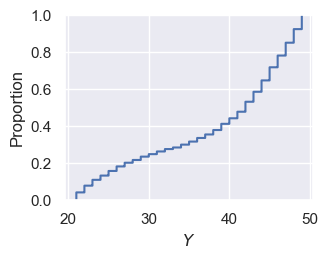

In [ ]:
sns.ecdfplot(data=xi)
plt.gca().set_xlabel('$Y$')

plt.show()

b. Tentukan $Pr(Y^*>40) = Pr(Y>40 \mid Y>28)$ melalui suatu simulasi.

Simulasi dilakukan dengan algoritma berikut.

<!-- $a$ -->
<ol>
    <li>Bangkitkan secara uniform sebuah bilangan real antara 0 dan 1, misal $p$</li>
    <li>Realisasi yang bersesuaian adalah $x=\hat{F}^{-1}(p)$ yang didefinisikan sebagai nilai $y$ terkecil sedemikian sehingga $\hat{F}(y) > p$</li>
    <li>Simpan sebagai sampel acak jika dan hanya jika realisasi memenuhi syarat</li>
    <li>Kembali ke langkah pertama hingga ukuran sampel sesuai dengan yang diinginkan</li>
    <li>Taksir peluang lewat fungsi distribusi empiris sampel</li>
</ol>

In [ ]:
SAMPLE_SIZE = 20000
CONDITION = pd.Interval(left=28, right=np.inf, closed='neither')
TARGET = pd.Interval(left=40, right=np.inf, closed='neither')

samples = []
np.random.seed(42)

# Algorithm
while len(samples) < SAMPLE_SIZE:
    p = np.random.uniform(0,1)
    # Smallest yj such that Fj > p
    x = df['yj'][df['Fj'] > p].min()
    if x in CONDITION:
        samples.append(x)

samples = [sample in TARGET for sample in samples]
print(f"Taksiran Pr(Y > 40 | Y > 28) adalah: {np.mean(samples)}")

Taksiran Pr(Y > 40 | Y > 28) adalah: 0.7119


c. Dapatkan $VaR$ dari $Y$ dengan tingkat kepercayaan $99\%$ yang dievaluasi dari fungsi kuantil empiris.

Formula $VaR$ dengan menggunakan fungsi kuantil empiris:

\begin{align}
VaR_{\alpha} (Y)=\bigg (\frac{g_{j+1}-(n+1)\alpha}{w_{j+1}} \bigg )y_{j} + \bigg (\frac{(n+1)\alpha-g_{j}}{w_{j+1}} \bigg )y_{j+1} 
    \end{align}

In [ ]:
ALPHA = 0.99

n = len(xi)
j = df['gj'][df['gj'] <= ALPHA * (n+1)].index.max()

VaR = (df['gj'][j+1]-(n+1)*ALPHA) / df['wj'][j+1] * df['yj'][j]
VaR += ((n+1)*ALPHA-df['gj'][j]) / df['wj'][j+1] * df['yj'][j+1]

print(f"Taksiran VaR_0.99: {VaR}")

Taksiran VaR_0.99: 48.87155405405405


d. Tuliskan formula penaksir Kaplan-Meier untuk fungsi kesintasan. Buat fungsi kesintasan $Y$ dan tampilkan hasilnya.

Formula penaksir Kaplan-Meier untuk fungsi kesintasan: 

\begin{align*}
    \hat{S}_{K}(y) = \left\{
    \begin{array}{cl}
    1 & ,0 < y < y_{1} \\
    \prod_{h=1}^j (1-\frac{w_{h}}{r_{h}}) & ,y_{j} \le y < y_{j+1}, j=1, ..., m-1 \\
    \prod_{h=1}^m (1-\frac{w_{h}}{r_{h}}) & ,y_{m} \le y.
    \end{array}
    \right.
\end{align*}

In [ ]:
def get_S_hat(ys: np.ndarray, Sy: pd.Series) -> np.ndarray:
    """Get the value of S_hat for a given sample of ys and Sy

    Args:
        ys (np.ndarray): Argument for Sy
        Sy (pd.Series): The estimate of survival function, indexed as yj

    Returns:
        np.ndarray: List of S_hat(ys)
    """
    res = np.ones_like(ys, dtype='float')
    for i, y in enumerate(ys):
        # Modify if y >= y1, else the value of 1 is correct
        if y >= Sy.index.min():
            imax = Sy.index[Sy.index <= y].max()
            res[i] = Sy[imax]
    return res

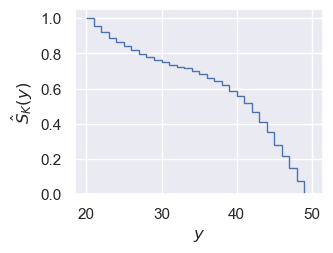

In [ ]:
wj = wj.sort_index(ascending=False)
rj = wj.cumsum()
SKy = (1 - wj / rj).sort_index().cumprod()

ys = np.arange(xi.min()-1, xi.max()+1)

plt.stairs(values=get_S_hat(ys,SKy), edges=np.append(ys,xi.max()+1), baseline=None)
plt.xlabel('$y$')
plt.ylabel('$\hat{S}_{K}(y)$')

plt.show()

#### 2. Penaksir Nelson-Aalen.

a. Konstruksikan penaksir N-A untuk fungsi kesintasan. Bentuk algoritma perhitungan penaksir N-A diberikan data titik waktu terjadinya kerugian $\mathbf{y}=(y_{1}, y_{2}, \ldots, y_{n})$.

Penaksir N-A untuk fungsi kesintasan: 

\begin{align*}
    \hat{S}_{N}(y) = \left\{
    \begin{array}{cl}
    1 & ,0 < y < y_{1} \\
    \text{exp}(-\sum_{h=1}^j \frac{w_{h}}{r_{h}}) & ,y_{j} \le y < y_{j+1}, j=1, ..., m-1 \\
    \text{exp}(-\sum_{h=1}^m \frac{w_{h}}{r_{h}}) & ,y_{m} \le y.
    \end{array}
    \right.
\end{align*}

Algoritma untuk menghitung penaksir N-A jika diberikan data titik waktu terjadinya kerugian:
<!-- $a$ -->
<ol>
    <li>Urutkan nilai $\mathbf{y}$ dari yang terkecil hingga nilai terbesar.</li>
    <li>Cari nilai-nilai observasi yang berbeda dari $\mathbf{y}$. Simpan nilai observasi tersebut pada variabel $y_{j}$ dengan $j=1,2,3,...,m$ dan $y_{i} \lt y_{j}$ untuk setiap $i \lt j$.</li>
    <li>Hitung banyaknya nilai observasi di $\mathbf{y}$ yang sama dengan $y_{j}$. Simpan nilai tersebut pada variabel $w_{j}$ dengan $j=1,2,3,...,m$.</li>
    <li>Hitung nilai $r_{j}$ menggunakan formula $r_{j}=r_{j-1}-w_{j-1}$.</li>
    <li>Taksir penaksir N-A dengan formula yang telah dikontruksikan diatas.</li>
</ol>

b. Visualisasi penaksir N-A untuk fungsi kesintasan menggunakan dataset Tugas 02. Hitung $\hat{S}(30)$.

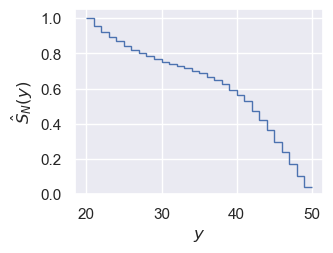

Taksiran S(30) dengan penaksir N-A: 0.7537955499719917


In [ ]:
SNy = np.exp(-(wj/rj).sort_index().cumsum())

ys = np.arange(xi.min()-1, xi.max()+1)

plt.stairs(values=get_S_hat(ys,SNy), edges=np.append(ys,xi.max()+1), baseline=None)
plt.xlabel('$y$')
plt.ylabel('$\hat{S}_{N}(y)$')

plt.show()

print(f"Taksiran S(30) dengan penaksir N-A: {get_S_hat([30], SNy)[0]}")

#### 3. Tinjau data banyak dan besar klaim dari suatu perusahaan asuransi umum di https://bit.ly/2022-modris2-tugas04-dataset.

a. Tentukan distribusi banyak dan besar klaim yang sesuai.

In [ ]:
df = pd.read_excel('dataset-claim-ABC.xlsx')
mapper = {'property_claim_size (SGD)': 'x', 'claim_number': 'n'}
df = df.rename(columns=mapper)

Distribusi yang akan dicoba adalah distribusi dari keluarga eksponensial. Untuk banyak klaim, akan dicoba Binomial, Poisson, dan Negative Binomial. Untuk distribusi Binomial dan Negative Binomial, fitting dilakukan dengan metode maximum likelihood secara numerik. Untuk distribusi Poisson, taksiran maximum likelihood dari parameternya diberikan oleh rata-rata sampel. Distribusi terbaik yang dipilih adalah distribusi dengan nilai AIC terkecil.

In [ ]:
np.random.seed(42)
freq_dist_names = ['Binomial', 'Negative Binomial']
freq_dist_gens = [stats.binom, stats.nbinom]

# Fitting, listing parameters, and AIC
for dist, name in zip(freq_dist_gens, freq_dist_names):
    res = stats.fit(dist, df['n'], bounds={'n': (0,100000)})
    print(f"Parameter {name}: {res.params[:2]}")
    nll = res.nllf()
    aic = 2*dist.numargs + 2*nll
    print(f"AIC {name}: {aic}\n")

print(f"Parameter Poisson: {(df['n'].mean(),)}")
nll = np.sum(-stats.poisson(df['n'].mean()).logpmf(df['n']))
aic = 2*stats.poisson.numargs + 2*nll
print(f"AIC Poisson: {aic}")

Parameter Binomial: (1158.0, 0.012969015516431707)
2
AIC Binomial: 17977.31837604997

Parameter Negative Binomial: (30872.0, 0.9995137672295467)
2
AIC Negative Binomial: 17977.67700627201

Parameter Poisson: (15.018125960061443,)
AIC Poisson: 17975.653885547865


Untuk besar klaim, akan dicoba Gamma, Inverse Gaussian, dan Normal. Untuk distribusi Normal, taksiran maximum likelihood dari parameternya diberikan oleh rata-rata dan standar deviasi sampel.

In [ ]:
dist_names = ['Gamma', 'Inverse Gaussian']
dist_gens = [stats.gamma, stats.invgauss]

# Fitting, listing parameters, and AIC
for dist, name in zip(dist_gens, dist_names):
    param = dist.fit(df['x'], floc=0)
    print(f"Parameter {name}: {param[::2]}")
    
    nll = np.sum(-dist(*param).logpdf(df['x']))
    aic = 2*dist.numargs + 2*nll
    print(f"AIC {name}: {aic}\n")

param = (df['x'].mean(), df['x'].std())
print(f"Parameter Normal: {param}")

nll = np.sum(-stats.norm(*param).logpdf(df['x']))
aic = 2*stats.norm.numargs + 2*nll
print(f"AIC Normal: {aic}")

Parameter Gamma: (50.72224535687595, 9.863689539928108)
AIC Gamma: 36877.09362369882

Parameter Inverse Gaussian: (0.020120595519306353, 24865.490710164242)
AIC Inverse Gaussian: 36889.76103368817

Parameter Normal: (500.30848096828447, 70.24683636244966)
AIC Normal: 36916.90927978109


b. Definisikan $S$ peubah acak klaim agregat dengan melibatkan distribusi banyak klaim dan besar klaim.

Karena AIC Poisson terkecil untuk data banyak klaim dan AIC Gamma terkecil untuk besar klaim, dipilih distribusi compound Poisson-Gamma untuk $S$ yang merupakan peubah acak klaim agregat. Peubah acak ini didefinisikan sebagai berikut: 
\begin{align*}
    S_{N}=\sum_{i=1}^{N}{X_{i}}=X_{1}+X_{2}+X_{3}+...+X_{N}
\end{align*}
dengan $N \sim Poisson(15.018125960061443)$ merupakan peubah acak banyak klaim primer dan $X_{i} \sim Gamma(50.72224535687595, 9.863689539928108)$ merupakan peubah acak besar klaim sekunder. 

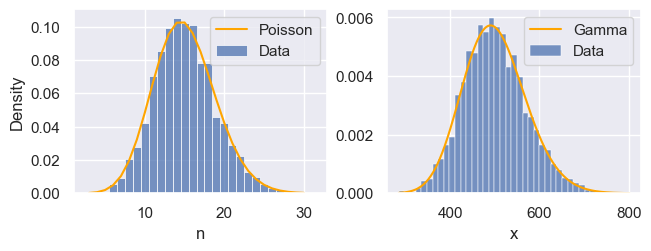

In [ ]:
freq_dist = stats.poisson(df['n'].mean())
sev_dist = stats.gamma(*stats.gamma.fit(df['x'], floc=0))

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=[1*6.4, 0.5*4.8])

# Frequency
sns.histplot(df, x='n', discrete=True, stat='density', label='Data', ax=axs[0])
x = np.arange(df['n'].min(), df['n'].max())
axs[0].plot(x, freq_dist.pmf(x), label='Poisson', color='orange')
axs[0].legend()

# Severity
sns.histplot(df, x='x', stat='density', label='Data', ax=axs[1])
x = np.arange(df['x'].min(), df['x'].max())
axs[1].plot(x, sev_dist.pdf(x), label='Gamma', color='orange')
axs[1].legend()
axs[1].set_ylabel('')

plt.show()

c. Diberikan $\Pr(|\frac{S-\mu_{S}}{\sigma_{S}}| \leq s)=0.95$ dengan $\mu_{S}$ dan $\sigma_{S}^{2}$ mean dan variansi analitik $S$. Tentukan algoritma optimasi untuk mendapatkan $s$. Hitung $s$.

Menurut Klugman, et al. (2019), nilai $s$ yang memenuhi diberikan oleh
\begin{equation*}
  s = \inf_{s}{\left[\Pr\left(\left|\frac{S-\mu_{S}}{\sigma_{S}}\right| \leq s \right) \geq 0.95\right]}.
\end{equation*}

Secara analitik, $\mu_{S} = E[N]E[X]$ dan $\sigma^{2}_{S} = E[N]Var(X) + Var(N)E[X]^{2}$ (Tse, 2009). Kedua nilai ini didapat dari distribusi pada 3b, yaitu $\mu_{S}=7513.695786068699$ dan $\sigma^{2}_{S}=3833278.4877170785$. Dengan demikian, taksiran yang diperlukan hanyalah fungsi distribusi. Taksiran ini akan didapat dengan membangkitkan $S$ secara acak. Algoritma optimisasi yang digunakan adalah sebagai berikut:

1. Bangkitkan sampel acak dari $S$, misal $x$
2. Hitung $|\frac{x-\mu_{S}}{\sigma_{S}}|$, simpan sebagai sampel
3. Kembali ke 1 hingga ukuran sampel mencukupi
4. Cari nilai $s=\arg\min_{s}{[\Pr(|\frac{S-\mu_{S}}{\sigma_{S}}| \leq s ) - 0.95]^{2}}$ dengan $\Pr(|\frac{S-\mu_{S}}{\sigma_{S}}| \leq s )$ ditaksir oleh banyaknya sampel yang kurang dari atau sama dengan $s$ dibagi dengan banyaknya sampel.

In [ ]:
SAMPLE_SIZE = 10000
ALPHA = 0.05

mu_s = freq_dist.mean() * sev_dist.mean()
sigmasq_s = freq_dist.mean() * sev_dist.var() + freq_dist.var() * sev_dist.mean()**2
sigma_s = np.sqrt(sigmasq_s)

np.random.seed(42)
def get_data(n, freq_dist, sev_dist):
    """
    Create a dataset of n samples from the given frequency and severity
    distributions.

    Args:
        n (int): number of samples
        freq_dist (stats.rv_discrete): distribution of frequency
        sev_dist (stats.rv_continuous): distribution of severity

    Returns:
        np.ndarray: Samples of size n
    """
    freqs = freq_dist.rvs(n)
    aggs = []
    for freq in freqs:
        aggs.append(np.sum(sev_dist.rvs(freq)))
    return np.array(aggs)

data = np.abs((get_data(SAMPLE_SIZE, freq_dist, sev_dist) - mu_s) / sigma_s)
loss = lambda s, data: (np.sum(data <= s) / len(data) - (1-ALPHA))**2

s = optimize.minimize_scalar(loss, args=(data,)).x
print(f"Nilai s hasil optimisasi adalah: {s}")

Nilai s hasil optimisasi adalah: 1.9716269740401546


d. Dengan $\alpha=5\%$ dan 3c, apakah klaim agregat mencapai kredibilitas penuh?

Klaim agregat mencapai kredibilitas penuh apabila
\begin{align*}
\lambda_{N}\geq \bigg(\displaystyle\frac{z_{1-\frac{\alpha}{2}}}{k}\bigg)^2\bigg(\displaystyle\frac{(E(X))^2+Var(X)}{(E(X))^2}\bigg).
\end{align*}

Nilai $\lambda_{N}=15.018125960061443$, $E[X]=500.3084809682844$, dan $Var(X)=4934.887530464188$. Nilai $k$ dapat dihitung dari ekspresi pada 3c. Pandang $\left|\frac{S-\mu_{S}}{\sigma_{S}}\right| \leq s$ ekivalen dengan $\left|\frac{S-\mu_{S}}{\sigma_{S}}\right| \leq \frac{k\mu_{S}}{\sigma_{S}}$ sehingga $k=s\frac{\sigma_{S}}{\mu_{S}}$.

In [ ]:
ALPHA = 0.05

lambda_N = freq_dist.mean()
z = stats.norm().ppf(1-ALPHA/2)
k = s * sigma_s/mu_s
Ex = sev_dist.mean()
VarX = sev_dist.var()

full_credibility = lambda_N >= (z/k)**2 * (Ex**2 + VarX)/Ex**2
print(f"Apakah klaim agregat mencapai kredibilitas penuh: {full_credibility}")

Apakah klaim agregat mencapai kredibilitas penuh: True


#### Referensi

Tse, Yiu-Kuen. (2009). *Nonlife Actuarial Models Theory, Methods and Evaluation*. New York: Cambridge University Press.

Hogg, R., McKean, J., Craig, A. (2019) Introduction to Mathematical Statistics. 8th Edition. Boston: Pearson.

Taboga, Marco (2021). "Maximum likelihood - Numerical optimization algorithm", Lectures on probability theory and mathematical statistics. Kindle Direct Publishing. Online appendix. https://www.statlect.com/fundamentals-of-statistics/maximum-likelihood-algorithm.

Michael L. Waskom (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021.

Virtanen, P., Et al. (2020). SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17, 261–272.

Klugman, Stuart A., Panjer, Harry H., Willmot, Gordon E. (2019). *Loss Models: From Data To Decisions*. 5th Edition. Hoboken: John Wiley & Sons, Inc.